<a href="https://colab.research.google.com/github/tnc-br/ddf-isoscapes/blob/boosting/dnn/variational_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational model

Find the mean/variance of O18 ratios (as well as N15 and C13 in the future) at a particular lat/lon across Brazil. At the bottom of the colab, train and evaluate 4 different versions of the model with different data partitioning strategies.

In [2]:
from collections import defaultdict
import math
import numpy as np
import pandas as pd
import datetime
import os
from typing import List, Tuple, Dict
from dataclasses import dataclass
from joblib import dump


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from matplotlib import pyplot as plt
from tensorflow.python.ops import math_ops
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.compose import ColumnTransformer

#@title Debugging
# See https://zohaib.me/debugging-in-google-collab-notebook/ for tips,
# as well as docs for pdb and ipdb.
DEBUG = False #@param {type:"boolean"}
USE_LOCAL_DRIVE = True #@param {type:"boolean"}
LOCAL_DIR = "/usr/local/google/home/ruru/Downloads/amazon_sample_data-20230712T203059Z-001" #@param
GDRIVE_DIR = "MyDrive/amazon_rainforest_files/" #@param
FP_ROOT = LOCAL_DIR

MODEL_SAVE_LOCATION = "/usr/local/google/home/ruru/Downloads/model_builds" #@param

def get_model_save_location(filename) -> str:
  root = '' if USE_LOCAL_DRIVE else '/content/drive'
  return os.path.join(root, MODEL_SAVE_LOCATION, filename)

# Access data stored on Google Drive if not reading data locally.
if not USE_LOCAL_DRIVE:
  from google.colab import drive
  drive.mount('/content/drive')
  global FP_ROOT
  FP_ROOT = os.path.join('/content/drive', GDRIVE_DIR)

if DEBUG:
    %pip install -Uqq ipdb
    import ipdb
    %pdb on

2023-08-03 20:38:16.877286: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-03 20:38:16.912915: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-03 20:38:16.913977: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 20:38:17.625778: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data preparation


In [11]:
def load_dataset(path: str, columns_to_keep: List[str]):
  df = pd.read_csv(path, encoding="ISO-8859-1", sep=',')
  df = df[df['d18O_cel_variance'].notna()]

  X = df
  X = X.drop(df.columns.difference(columns_to_keep), axis=1)

  Y = df[["d18O_cel_mean", "d18O_cel_variance"]]
  return X, Y

# Standardization

In [21]:
@dataclass
class FeaturesToLabels:
  def __init__(self, X: pd.DataFrame, Y: pd.DataFrame):
    self.X = X
    self.Y = Y

  def as_tuple(self):
    return (self.X, self.Y)


def create_feature_scaler(X: pd.DataFrame,
                          columns_to_passthrough,
                          columns_to_scale,
                          columns_to_standardize) -> ColumnTransformer:
  feature_scaler = ColumnTransformer(
      [(column+'_normalizer', MinMaxScaler(), [column]) for column in columns_to_scale] +
      [(column+'_standardizer', StandardScaler(), [column]) for column in columns_to_standardize],
      remainder='passthrough')
  feature_scaler.fit(X)
  print(feature_scaler)
  return feature_scaler

def scale(X: pd.DataFrame, feature_scaler):
  # transform() outputs numpy arrays :(  need to convert back to DataFrame.
  X_standardized = pd.DataFrame(feature_scaler.transform(X),
                        index=X.index, columns=X.columns)
  return X_standardized

In [25]:
# Just a class organization, holds each scaled dataset and the scaler used.
# Useful for unscaling predictions.
@dataclass
class ScaledPartitions():
  def __init__(self,
               feature_scaler: ColumnTransformer,
               label_scaler: ColumnTransformer,
               train: FeaturesToLabels, val: FeaturesToLabels,
               test: FeaturesToLabels):
    self.feature_scaler = feature_scaler
    self.label_scaler = label_scaler
    self.train = train
    self.val = val
    self.test = test


def load_and_scale(config: Dict,
                   columns_to_passthrough: List[str],
                   columns_to_scale: List[str],
                   columns_to_standardize: List[str]) -> ScaledPartitions:
  columns_to_keep = columns_to_passthrough + columns_to_scale + columns_to_standardize
  X_train, Y_train = load_dataset(config['TRAIN'], columns_to_keep)
  X_val, Y_val = load_dataset(config['VALIDATION'], columns_to_keep)
  X_test, Y_test = load_dataset(config['TEST'], columns_to_keep)

  # Fit the scaler:
  feature_scaler = create_feature_scaler(
      X_train,
      columns_to_passthrough,
      columns_to_scale,
      columns_to_standardize)

  # Apply the scaler:
  train = FeaturesToLabels(scale(X_train, feature_scaler), Y_train)
  val = FeaturesToLabels(scale(X_val, feature_scaler), Y_val)
  test = FeaturesToLabels(scale(X_test, feature_scaler), Y_test)
  return ScaledPartitions(feature_scaler, None, train, val, test)


# Model Definition



The KL Loss function:

In [13]:
def sample_normal_distribution(
    mean: tf.Tensor,
    stdev: tf.Tensor,
    n: int) -> tf.Tensor:
    '''
    Given a batch of normal distributions described by a mean and stdev in
    a tf.Tensor, sample n elements from each distribution and return the mean
    and standard deviation per sample.
    '''
    batch_size = tf.shape(mean)[0]

    # Output tensor is (n, batch_size, 1)
    sample_values = tfp.distributions.Normal(
        loc=mean,
        scale=stdev).sample(
            sample_shape=n)
    # Reshaped tensor will be (batch_size, n)
    sample_values = tf.transpose(sample_values)
    # Get the mean per sample in the batch.
    sample_mean = tf.transpose(tf.math.reduce_mean(sample_values, 2))
    sample_stdev = tf.transpose(tf.math.reduce_std(sample_values, 2))

    return sample_mean, sample_stdev

import tensorflow_probability as tfp

# log(σ2/σ1) + ( σ1^2+(μ1−μ2)^2 ) / 2* σ^2   − 1/2
def kl_divergence_helper(real, predicted, sample):
    '''
    real: tf.Tensor of the real mean and standard deviation of sample to compare
    predicted: tf.Tensor of the predicted mean and standard deviation to compare
    sample: Whether or not to sample the predicted distribution to get a new
            mean and standard deviation.
    '''
    if real.shape != predicted.shape:
      raise ValueError(
          f"real.shape {real.shape} != predicted.shape {predicted.shape}")

    real_value = tf.gather(real, [0], axis=1)
    real_std = tf.math.sqrt(tf.gather(real, [1], axis=1))


    predicted_value = tf.gather(predicted, [0], axis=1)
    predicted_std = tf.math.sqrt(tf.gather(predicted, [1], axis=1))
    # If true, sample from the distribution defined by the predicted mean and
    # standard deviation to use for mean and stdev used in KL divergence loss.
    if sample:
      predicted_value, predicted_std = sample_normal_distribution(
          mean=predicted_value, stdev=predicted_std, n=15)

    kl_loss = -0.5 + tf.math.log(predicted_std/real_std) + \
     (tf.square(real_std) + tf.square(real_value - predicted_value))/ \
     (2*tf.square(predicted_std))

    if tf.math.is_nan(tf.math.reduce_mean(kl_loss)):
       tf.print(predicted)
       sess = tf.compat.v1.Session()
       sess.close()

    return tf.math.reduce_mean(kl_loss)

def kl_divergence(real, predicted):
  return kl_divergence_helper(real, predicted, True)

Test the loss function:

In [ ]:
import pytest

class TensorsDifferShapeTest(unittest.TestCase):
   def test(self):
      test_real = tf.convert_to_tensor(np.array([[1, 0.02]]))
      test_pred = tf.convert_to_tensor(np.array([[0.98]]))
      with self.assertRaises(ValueError):
         kl_divergence(test_real, test_pred, False)
         assert(False) # Triggers if no exception is caught in the previous line.

TensorsDifferShapeTest().test()

test_real = tf.convert_to_tensor(np.array([[1, 0.02]]))
test_pred = tf.convert_to_tensor(np.array([[0.98, 0.021]]))

# https://screenshot.googleplex.com/5WM9dinAbhR26ZS
assert float(kl_divergence(test_real, test_pred)) == pytest.approx(0.0101094, 1e-5)

test_neg_real = tf.convert_to_tensor(np.array([[32.32, 0.0344]]))
test_neg_pred = tf.convert_to_tensor(np.array([[32.01, -0.322]]))

# Negative variance causes NaN
assert tf.math.is_nan(kl_divergence(test_neg_real, test_neg_pred))

# Calculated manually by computing the result of this equation in wolfram alpha:
# log(σ2/σ1) + ( σ1^2+(μ1−μ2)^2 ) / 2* σ^2   − 1/2
test_real_2d = tf.convert_to_tensor(np.array(
    [[1.00, 0.020],
     [1.01, 0.042]]))
test_pred_2d = tf.convert_to_tensor(np.array(
    [[0.98, 0.021],
     [0.99, 0.012]]))

# Should reduce to the average loss of all rows.
assert float(kl_divergence(test_real_2d, test_pred_2d)) == pytest.approx(
    sum([0.0101094, 0.6402851])/2, 1e-5)

# Model definition

In [23]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

tf.keras.utils.set_random_seed(18731)

def get_early_stopping_callback():
  return EarlyStopping(monitor='val_loss', patience=1000, min_delta=0.001,
                       verbose=1, restore_best_weights=True, start_from_epoch=0)

# I was experimenting with models that took longer to train, and used this
# checkpointing callback to periodically save the model. It's optional.
def get_checkpoint_callback(model_file):
  return ModelCheckpoint(
      get_model_save_location(model_file),
      monitor='val_loss', verbose=0, save_best_only=True, mode='min')

def train_or_update_variational_model(
        sp: ScaledPartitions,
        hidden_layers: List[int],
        epochs: int,
        batch_size: int,
        lr: float,
        model_file=None,
        use_checkpoint=False):
  callbacks_list = [get_early_stopping_callback(),
                    get_checkpoint_callback(model_file)]
  if not use_checkpoint:

    # Find the kriging columns and make sure they are at the end of the dataframe.
    krig_mean_index = sp.train.X.columns.get_loc('ordinary_kriging_linear_d18O_predicted_mean')
    krig_var_index = sp.train.X.columns.get_loc('ordinary_kriging_linear_d18O_predicted_variance')
    if (krig_mean_index != sp.train.X.shape[1]-2 and krig_var_index != sp.train.X.shape[1]-1):
      raise ValueError("ordinary_kriging_linear_d18O_predicted_mean and"
      "ordinary_kriging_linear_d18O_predicted_variance must be"
      "located in the last two columns of dataframe")

    inputs = keras.Input(shape=(sp.train.X.shape[1],))
    nn = inputs[:,0:-2]
    krig_mean = tf.expand_dims(inputs[:,-2], 1)
    krig_variance = tf.expand_dims(inputs[:, -1], 1)

    for layer_size in hidden_layers:
      nn = keras.layers.Dense(layer_size, activation='relu')(nn)

    # Invert the normalization on our outputs, and add kriging predictions as
    # constants so the network only predicts the residuals.
    pred_mean_residual = keras.layers.Dense(1, name='pred_mean_residual')(nn)
    pred_var_residual = keras.layers.Dense(1, name='pred_var_output')(nn)

    pred_mean = krig_mean + pred_mean_residual
    pred_var = keras.layers.Lambda(lambda t: tf.math.log(1 + tf.math.exp(t[0]+t[1])))([krig_variance, pred_var_residual])

    # Output mean, variance tuples.
    outputs = keras.layers.concatenate([pred_mean, pred_var])
    model = keras.Model(inputs=inputs, outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=kl_divergence)
    model.summary()
  else:
    model = keras.models.load_model(
        get_model_save_location(model_file),
        custom_objects={"kl_divergence": kl_divergence})
  history = model.fit(sp.train.X, sp.train.Y, verbose=0, epochs=epochs,
                      batch_size=batch_size,
                      validation_data=sp.val.as_tuple(),
                      shuffle=True, callbacks=callbacks_list)
  return history, model

In [15]:
from sklearn.metrics import mean_squared_error

def render_plot_loss(history, name):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(name + ' model loss')
  plt.ylabel('loss')
  plt.yscale("log")
  plt.ylim((0, 10))
  plt.xlabel('epoch')
  plt.legend(['loss', 'val_loss'], loc='upper left')
  plt.show()

def destandardize(sd: ScaledPartitions, df: pd.DataFrame):
  means = pd.DataFrame(
      sd.label_scaler.named_transformers_['var_std_scaler'].inverse_transform(df[['d18O_cel_mean']]),
      index=df.index, columns=['d18O_cel_mean'])
  vars = df['d18O_cel_variance']
  return means.join(vars)

def train_and_evaluate(sp: ScaledPartitions, run_id: str, training_batch_size=5):
  print("==================")
  print(run_id)
  history, model = train_or_update_variational_model(
      sp, hidden_layers=[20, 20], epochs=5000, batch_size=training_batch_size,
      lr=0.001, model_file=run_id+".h5", use_checkpoint=False)
  render_plot_loss(history, run_id+" kl_loss")
  model.save(get_model_save_location(run_id+".h5"), save_format="h5")

  best_epoch_index = history.history['val_loss'].index(min(history.history['val_loss']))
  print('Val loss:', history.history['val_loss'][best_epoch_index])
  print('Train loss:', history.history['loss'][best_epoch_index])
  print('Test loss:', model.evaluate(x=sp.test.X, y=sp.test.Y, verbose=0))

  predictions = model.predict_on_batch(sp.test.X)
  predictions = pd.DataFrame(predictions, columns=['d18O_cel_mean', 'd18O_cel_variance'])
  rmse = np.sqrt(mean_squared_error(sp.test.Y['d18O_cel_mean'], predictions['d18O_cel_mean']))
  print("dO18 RMSE: "+ str(rmse))
  print("EXPECTED:")
  print(sp.test.Y.to_string())
  print()
  print("PREDICTED:")
  print(predictions.to_string())
  return model

## 1) Grouped, random (jupyter crashed halfway so I reloaded a checkpoint)

We can't (easily) generate isoscapes with these because the isoscapes for 'predkrig_br_lat_ISORG', 'Iso_Oxi_Stack_mean_TERZER', 'isoscape_fullmodel_d18O_prec_REGRESSION' are not easily retrievable... but I'm curious how much better the model is if these columns are included.

Streaming output truncated to the last 5000 lines.
Epoch 590/10000
33/33 [==============================] - 0s 2ms/step - loss: 0.6870 - val_loss: 1.3445
Epoch 591/10000
33/33 [==============================] - 0s 2ms/step - loss: 0.6955 - val_loss: 1.3687
Epoch 592/10000
33/33 [==============================] - 0s 2ms/step - loss: 0.6882 - val_loss: 1.3965
Epoch 593/10000
33/33 [==============================] - 0s 2ms/step - loss: 0.6903 - val_loss: 1.3810
Epoch 594/10000
33/33 [==============================] - 0s 2ms/step - loss: 0.6888 - val_loss: 1.3446
Epoch 595/10000
33/33 [==============================] - 0s 2ms/step - loss: 0.6873 - val_loss: 1.3882
Epoch 596/10000
33/33 [==============================] - 0s 2ms/step - loss: 0.6927 - val_loss: 1.3234
Epoch 597/10000
33/33 [==============================] - 0s 2ms/step - loss: 0.6872 - val_loss: 1.3480
Epoch 598/10000
33/33 [==============================] - 0s 2ms/step - loss: 0.6898 - val_loss: 1.3412
Epoch 599/10000
33/33 

/tmp/ipykernel_3596556/3424320398.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


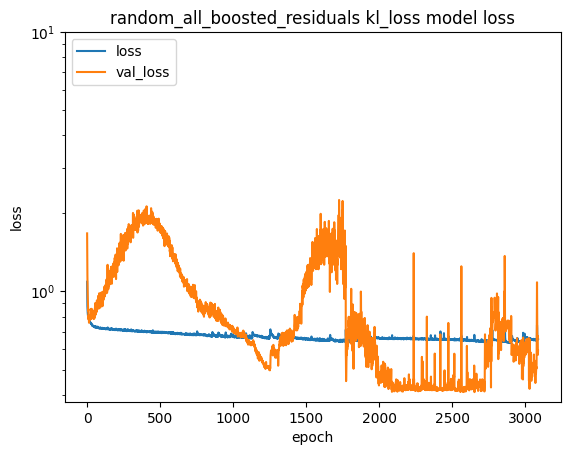

Val loss: 0.4091355800628662
Train loss: 0.651863694190979
Test loss: 0.8902407288551331
dO18 RMSE: 0.944438885031286
EXPECTED:
    d18O_cel_mean  d18O_cel_variance
0          26.130            0.19025
1          26.984            0.40123
2          24.656            0.17728
3          26.356            0.03953
4          23.962            0.30992
5          24.848            0.15842
6          25.080            0.05125
7          26.546            2.14378
8          25.682            0.94472
9          24.028            0.45852
10         23.944            0.15813
11         23.752            0.52437
12         26.018            0.96417

PREDICTED:
    d18O_cel_mean  d18O_cel_variance
0       26.645658           0.757585
1       26.645658           0.757585
2       24.900812           1.047868
3       25.676737           0.283033
4       24.921232           1.892284
5       23.815529           8.431017
6       23.815529           8.431017
7       24.921242           1.892245
8       2

2023-08-03 20:34:44.027000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [13,13]
	 [[{{node Placeholder/_0}}]]


['/usr/local/google/home/ruru/Downloads/model_builds/random_all_boosted_residuals_transformer.pkl']

In [8]:
grouped_random_fileset = {
    'TRAIN' : os.path.join(FP_ROOT, 'amazon_sample_data/canonical/uc_davis_train_random_grouped.csv'),
    'TEST' : os.path.join(FP_ROOT, 'amazon_sample_data/canonical/uc_davis_test_random_grouped.csv'),
    'VALIDATION' : os.path.join(FP_ROOT, 'amazon_sample_data/canonical/uc_davis_validation_random_grouped.csv'),
}

columns_to_passthrough = [
    'ordinary_kriging_linear_d18O_predicted_mean',
    'ordinary_kriging_linear_d18O_predicted_variance']
columns_to_scale = []
columns_to_standardize = [
    'lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA',
    'Mean Annual Temperature', 'Mean Annual Precipitation',
    'Iso_Oxi_Stack_mean_TERZER', 'isoscape_fullmodel_d18O_prec_REGRESSION']

data = load_and_scale(grouped_random_fileset, columns_to_passthrough, columns_to_scale, columns_to_standardize)
model = train_and_evaluate(data, "random_all_boosted_residuals", training_batch_size=3)
model.save(get_model_save_location("random_all_boosted_residuals.keras"), save_format='tf')
dump(data.feature_scaler, get_model_save_location('random_all_boosted_residuals_transformer.pkl'))


### 2) Grouped, random, ablating other models except kriging

We can generate isoscapes for this model easily.

ColumnTransformer(remainder='passthrough',
                  transformers=[('lat_standardizer', StandardScaler(), ['lat']),
                                ('long_standardizer', StandardScaler(),
                                 ['long']),
                                ('VPD_standardizer', StandardScaler(), ['VPD']),
                                ('RH_standardizer', StandardScaler(), ['RH']),
                                ('PET_standardizer', StandardScaler(), ['PET']),
                                ('DEM_standardizer', StandardScaler(), ['DEM']),
                                ('PA_standardizer', StandardScaler(), ['PA']),
                                ('Mean Annual Temperature_standardizer',
                                 StandardScaler(),
                                 ['Mean Annual Temperature']),
                                ('Mean Annual Precipitation_standardizer',
                                 StandardScaler(),
                                 ['Mean Annual

/tmp/ipykernel_3813950/3563715079.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


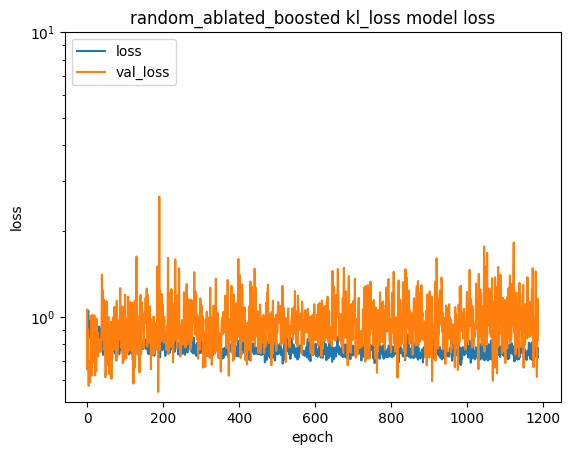

Val loss: 0.5435933470726013
Train loss: 0.7792006731033325
Test loss: 0.9979507923126221


2023-08-03 21:13:03.290520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [13,11]
	 [[{{node Placeholder/_0}}]]


dO18 RMSE: 0.984656242426217
EXPECTED:
    d18O_cel_mean  d18O_cel_variance
0          26.130            0.19025
1          26.984            0.40123
2          24.656            0.17728
3          26.356            0.03953
4          23.962            0.30992
5          24.848            0.15842
6          25.080            0.05125
7          26.546            2.14378
8          25.682            0.94472
9          24.028            0.45852
10         23.944            0.15813
11         23.752            0.52437
12         26.018            0.96417

PREDICTED:
    d18O_cel_mean  d18O_cel_variance
0       26.627794           0.897476
1       26.627794           0.897476
2       24.982353           1.202779
3       25.066158           1.204025
4       24.916113           2.477588
5       23.823303           8.910612
6       23.823303           8.910612
7       24.916119           2.477689
8       24.982349           1.202778
9       23.823301           8.910519
10      25.127268       

INFO:tensorflow:Assets written to: /usr/local/google/home/ruru/Downloads/model_builds/random_ablated_boosted.tf/assets


INFO:tensorflow:Assets written to: /usr/local/google/home/ruru/Downloads/model_builds/random_ablated_boosted.tf/assets


['/usr/local/google/home/ruru/Downloads/model_builds/random_ablated_boosted_transformer.pkl']

In [20]:
grouped_random_fileset = {
    'TRAIN' : os.path.join(FP_ROOT, 'amazon_sample_data/canonical/uc_davis_train_random_grouped.csv'),
    'TEST' : os.path.join(FP_ROOT, 'amazon_sample_data/canonical/uc_davis_test_random_grouped.csv'),
    'VALIDATION' : os.path.join(FP_ROOT, 'amazon_sample_data/canonical/uc_davis_validation_random_grouped.csv'),
}

columns_to_passthrough = [
    'ordinary_kriging_linear_d18O_predicted_mean',
    'ordinary_kriging_linear_d18O_predicted_variance']
columns_to_scale = []
columns_to_standardize = ['lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA',
    'Mean Annual Temperature', 'Mean Annual Precipitation',]

data = load_and_scale(grouped_random_fileset, columns_to_passthrough, columns_to_scale, columns_to_standardize)
model = train_and_evaluate(data, "random_ablated_boosted", training_batch_size=3)
model.save(get_model_save_location("random_ablated_boosted.tf"), save_format='tf')
dump(data.feature_scaler, get_model_save_location('random_ablated_boosted_transformer.pkl'))

### 3) Grouped, fixed, all columns

We can't (easily) generate isoscapes with these because the isoscapes for 'predkrig_br_lat_ISORG', 'Iso_Oxi_Stack_mean_TERZER',
                   'isoscape_fullmodel_d18O_prec_REGRESSION' are not easily retrievable... but I'm curious how much better the model is if these columns are included.

ColumnTransformer(remainder='passthrough',
                  transformers=[('lat_standardizer', StandardScaler(), ['lat']),
                                ('long_standardizer', StandardScaler(),
                                 ['long']),
                                ('VPD_standardizer', StandardScaler(), ['VPD']),
                                ('RH_standardizer', StandardScaler(), ['RH']),
                                ('PET_standardizer', StandardScaler(), ['PET']),
                                ('DEM_standardizer', StandardScaler(), ['DEM']),
                                ('PA_standardizer'...
                                ('Mean Annual Temperature_standardizer',
                                 StandardScaler(),
                                 ['Mean Annual Temperature']),
                                ('Mean Annual Precipitation_standardizer',
                                 StandardScaler(),
                                 ['Mean Annual Precipitation']),
      

/tmp/ipykernel_3813950/3563715079.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


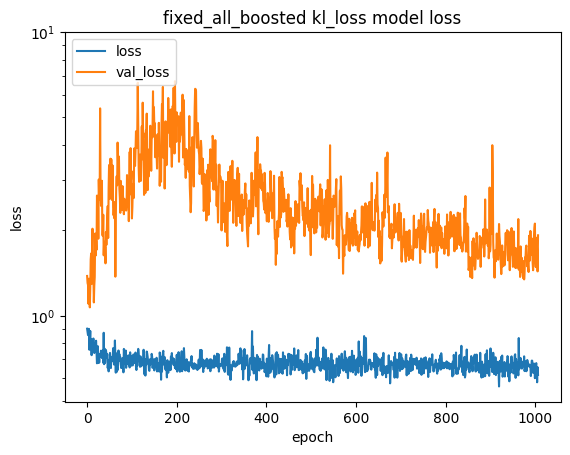

Val loss: 1.0689153671264648
Train loss: 0.8149141669273376
Test loss: 1.2395533323287964
dO18 RMSE: 1.2603639060315739
EXPECTED:
    d18O_cel_mean  d18O_cel_variance
0       24.042000           0.345970
1       25.240000           0.035950
2       25.782000           0.372220
3       25.076000           0.230280
4       25.966000           0.172480
5       27.434000           0.501030
6       28.156000           0.999030
7       26.836000           0.120880
8       28.180000           0.778250
9       26.834000           0.094930
10      26.644000           0.488430
11      26.772000           0.373370
12      27.684280           1.216389
13      27.403235           0.892280
14      24.777670           0.736571
15      25.551850           0.312355
16      25.115885           0.033519
17      25.987815           5.280825
18      24.132031           0.389042
19      24.898000           0.236070
20      23.944000           0.158130
21      26.018000           0.964170

PREDICTED:
    d18

2023-08-03 21:06:57.938724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [22,13]
	 [[{{node Placeholder/_0}}]]


['/usr/local/google/home/ruru/Downloads/model_builds/fixed_all_boosted_transformer.pkl']

In [18]:
grouped_fixed_fileset = {
    'TRAIN' : os.path.join(FP_ROOT, 'amazon_sample_data/canonical/uc_davis_train_fixed_grouped.csv'),
    'TEST' : os.path.join(FP_ROOT, 'amazon_sample_data/canonical/uc_davis_test_fixed_grouped.csv'),
    'VALIDATION' : os.path.join(FP_ROOT, 'amazon_sample_data/canonical/uc_davis_validation_fixed_grouped.csv'),
}

columns_to_passthrough = [
    'ordinary_kriging_linear_d18O_predicted_mean',
    'ordinary_kriging_linear_d18O_predicted_variance']
columns_to_scale = []
columns_to_standardize = [
    'lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA',
    'Mean Annual Temperature','Mean Annual Precipitation',
    'Iso_Oxi_Stack_mean_TERZER',
    'isoscape_fullmodel_d18O_prec_REGRESSION']

data = load_and_scale(grouped_fixed_fileset, columns_to_passthrough, columns_to_scale, columns_to_standardize)
model = train_and_evaluate(data, "fixed_all_boosted", training_batch_size=3)
model.save(get_model_save_location("fixed_all_boosted.keras"), save_format='tf')
dump(data.feature_scaler, get_model_save_location('fixed_all_boosted_transformer.pkl'))

## 4) Grouped fixed, ablating other columns besides kriging

ColumnTransformer(remainder='passthrough',
                  transformers=[('lat_standardizer', StandardScaler(), ['lat']),
                                ('long_standardizer', StandardScaler(),
                                 ['long']),
                                ('VPD_standardizer', StandardScaler(), ['VPD']),
                                ('RH_standardizer', StandardScaler(), ['RH']),
                                ('PET_standardizer', StandardScaler(), ['PET']),
                                ('DEM_standardizer', StandardScaler(), ['DEM']),
                                ('PA_standardizer', StandardScaler(), ['PA']),
                                ('Mean Annual Temperature_standardizer',
                                 StandardScaler(),
                                 ['Mean Annual Temperature']),
                                ('Mean Annual Precipitation_standardizer',
                                 StandardScaler(),
                                 ['Mean Annual

/tmp/ipykernel_3813950/3563715079.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


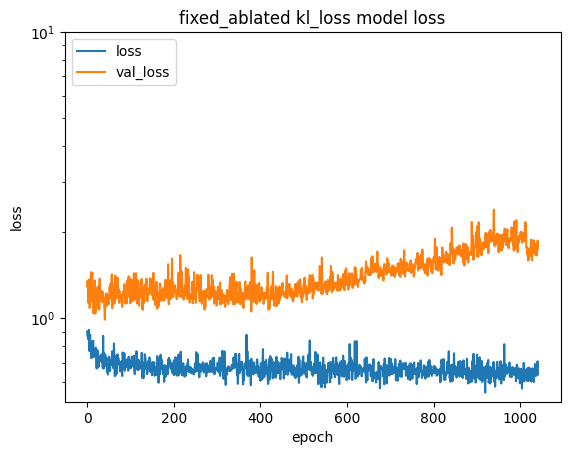

Val loss: 0.989641547203064
Train loss: 0.7396669387817383
Test loss: 1.236862063407898


2023-08-03 21:24:01.037850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [22,11]
	 [[{{node Placeholder/_0}}]]


dO18 RMSE: 1.1600789416900688
EXPECTED:
    d18O_cel_mean  d18O_cel_variance
0       24.042000           0.345970
1       25.240000           0.035950
2       25.782000           0.372220
3       25.076000           0.230280
4       25.966000           0.172480
5       27.434000           0.501030
6       28.156000           0.999030
7       26.836000           0.120880
8       28.180000           0.778250
9       26.834000           0.094930
10      26.644000           0.488430
11      26.772000           0.373370
12      27.684280           1.216389
13      27.403235           0.892280
14      24.777670           0.736571
15      25.551850           0.312355
16      25.115885           0.033519
17      25.987815           5.280825
18      24.132031           0.389042
19      24.898000           0.236070
20      23.944000           0.158130
21      26.018000           0.964170

PREDICTED:
    d18O_cel_mean  d18O_cel_variance
0       26.019182           0.635364
1       26.019182      

INFO:tensorflow:Assets written to: /usr/local/google/home/ruru/Downloads/model_builds/fixed_ablated_boosted.tf/assets


INFO:tensorflow:Assets written to: /usr/local/google/home/ruru/Downloads/model_builds/fixed_ablated_boosted.tf/assets


['/usr/local/google/home/ruru/Downloads/model_builds/fixed_ablated_boosted._transformer.pkl']

In [27]:
grouped_fixed_fileset = {
    'TRAIN' : os.path.join(FP_ROOT, 'amazon_sample_data/canonical/uc_davis_train_fixed_grouped.csv'),
    'TEST' : os.path.join(FP_ROOT, 'amazon_sample_data/canonical/uc_davis_test_fixed_grouped.csv'),
    'VALIDATION' : os.path.join(FP_ROOT, 'amazon_sample_data/canonical/uc_davis_validation_fixed_grouped.csv'),
}

columns_to_passthrough = [
    'ordinary_kriging_linear_d18O_predicted_mean',
    'ordinary_kriging_linear_d18O_predicted_variance']
columns_to_scale = []
columns_to_standardize =  ['lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA',
    'Mean Annual Temperature','Mean Annual Precipitation']

data = load_and_scale(grouped_fixed_fileset, columns_to_passthrough, columns_to_scale, columns_to_standardize)
model = train_and_evaluate(data, 'fixed_ablated', training_batch_size=3)
model.save(get_model_save_location('fixed_ablated_boosted.tf'), save_format='tf')
dump(data.feature_scaler, get_model_save_location('fixed_ablated_boosted._transformer.pkl'))